# Direct Preference Optimization (DPO)

Author: [Ufuk BIRBIRI.](https://www.linkedin.com/in/ufuk-birbiri-84881b213/)
Follow me on LinkedIn!

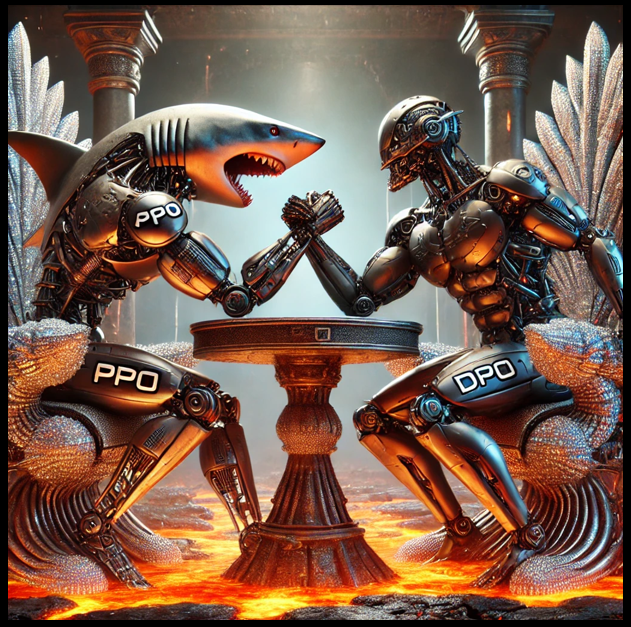

### What is DPO?

Training language models to align with human preferences is crucial for improving their usefulness and safety. Traditionally, this has been achieved through Reinforcement Learning with Human Feedback (RLHF) using Proximal Policy Optimization (PPO). While effective, this approach is computationally demanding and complex. Direct Preference Optimization (DPO) offers a more efficient alternative by directly aligning a model’s behavior with human preferences without relying on explicit reward modeling or reinforcement learning techniques.

### How DPO Works

`1. Collecting Human Preferences:` DPO begins by gathering human feedback on pairs of model responses, where one response is preferred over the other, referred as CHOSEN or REJECTED responses. These collected data is based on human feedback.

`2. Implicit Reward Model:` DPO does not explicitly use a reward function like traditional Reinforcement Learning with Human Feedback (RLHF) approaches such as Proximal Policy Optimization (PPO). Instead, DPO directly optimizes a policy using pairwise preference data without requiring a reward model.

`3. Policy Adjustment:` The model is updated to increase the likelihood of generating preferred responses while reducing the probability of less favorable ones. This adjustment is done dynamically for each example, ensuring that the model improves without introducing instability.

`4. Efficient Optimization:` Unlike traditional reinforcement learning, DPO directly integrates preference-based loss functions into standard training techniques. This simplifies the process, making it more scalable and computationally efficient.

By eliminating the need for explicit reward modeling and complex reinforcement learning algorithms, DPO streamlines preference-based fine-tuning, making it a practical solution for aligning AI models with human expectations.



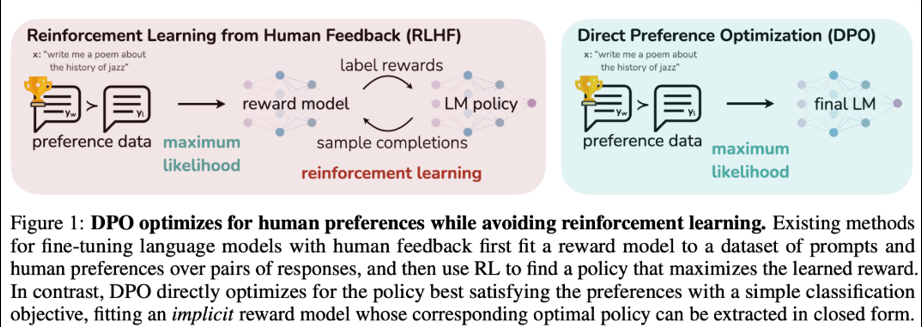

The above image is taken from the [original DPO paper.](https://arxiv.org/pdf/2305.18290) It shows the difference between PPO and DPO fine-tuning methods.

## Objectives

- Grasp the fundamentals of Direct Preference Optimization (DPO) and distinguish it from Proximal Policy Optimization (PPO).

- Construct a dataset tailored for DPO.
- Understand the required data format for DPO applications.
- Implement DPO by following a structured, step-by-step approach using the trl library.
- Define training parameters, initialize a quantized LoRA base model, and train it using a DPO trainer.
- Evaluate the LLM’s performance before and after applying DPO.



----


### Install libraries


In [1]:
!pip install torch
!pip install trl # for optimization training
!pip install peft # for creating LoRA architecture
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Import libraries


In [2]:
import multiprocessing
import os
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset

from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer,TrainingArguments, GPT2Tokenizer, set_seed, GenerationConfig
from trl import DPOConfig, DPOTrainer


## Create and configure the model and tokenizer


We will use the gpt2 as our model.

In [3]:

# Load model
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Load the reference model.
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define the end of sequence token
tokenizer.pad_token = tokenizer.eos_token
# Define the padding side as right to handle the overflow problem with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Dataset
We will use the [`argilla/ultrafeedback-binarized-preferences-cleaned`](https://huggingface.co/datasets/argilla/ultrafeedback-binarized-preferences-cleaned) dataset from HuggingFace. This dataset contains prompts and selected feedbacks labeled as CHOSEN or REJECTED. This dataset will serve as the human feedback.


In [4]:
# Load the dataset
dataset = load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")
dataset.keys()

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60917 [00:00<?, ? examples/s]

dict_keys(['train'])

In [5]:
dataset['train'][0]

{'source': 'evol_instruct',
 'prompt': 'Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here\'s some starter code to help you out:\n#include <iostream>\n#include <string>\nusing namespace std;\nint main() {\n    string country;\n    // prompt user for input\n    cout << "Enter the name of a country: ";\n    cin >> country;\n    // check if country borders the Mediterranean Sea\n    // [C++ code]\n    return 0;\n}',
 'chosen': [{'content': 'Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here\'s some starter code to help you out:\n#include <iostream>\n#include <string>\nusing namespace std;\nint main() {\n    string country;\n    // prompt user for input\n    cout << "Enter the name of a country: ";\n    cin >> country;\n    // check if country borders the Mediterranean Sea\n    // [C++ code]\n    return 0;\n}',
   'role': 'use

In [6]:
dataset["train"][0].keys()

dict_keys(['source', 'prompt', 'chosen', 'chosen-rating', 'chosen-model', 'rejected', 'rejected-rating', 'rejected-model'])

In [7]:
import multiprocessing
from datasets import load_dataset

# Reduce dataset volume by selecting the first 50 examples from each split
for key in dataset.keys():
    dataset[key] = dataset[key].select(range(50))


# Function to process data
def process(data_point):
    # Remove unwanted columns safely
    for col in ['source', 'chosen-rating', 'chosen-model', 'rejected-rating', 'rejected-model']:
        data_point.pop(col, None)  # Avoids errors if the column is missing

    # Extract the last response content
    data_point["chosen"] = data_point["chosen"][-1]["content"]
    data_point["rejected"] = data_point["rejected"][-1]["content"]

    return data_point

# Apply mapping to process al the rows
dataset = dataset.map(process, num_proc=multiprocessing.cpu_count(), load_from_cache_file=False,)

# Split train dataset: 90% for training, 10% for testing
ds_train_test = dataset["train"].train_test_split(test_size=0.1)

# Assign new splits
dataset["train"], dataset["test"] = ds_train_test["train"], ds_train_test["test"]

train_dataset = dataset["train"]
eval_dataset = dataset["test"]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 45
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 5
    })
})

Let's check the data record.


In [9]:
train_dataset[0]

{'prompt': "Let's play a puzzle game! Can you connect the dots and figure out how rising global temperatures, changes in precipitation patterns, and sea level rise are all connected? The solution lies in understanding how these factors impact ecosystems, biodiversity, and natural resources. So, can you solve this puzzle and explain how climate change affects the environment?",
 'chosen': "Of course, I'd be happy to help you solve the puzzle and understand how rising global temperatures, changes in precipitation patterns, and sea level rise are connected!\nFirstly, let's define what climate change is and why it's important to understand its impact on the environment. Climate change refers to the long-term warming of the planet due to an increase in the average global temperature, primarily caused by human activities such as burning fossil fuels, deforestation, and industrial processes. The increase in global temperature results in changes in precipitation patterns, sea level rise, and a

In [10]:
eval_dataset[0]

{'prompt': 'Using Python, create a program that analyzes a given text for words that have homonyms (words with the same spelling but different meanings) and replaces them with their intended meaning. For example, "I saw a bear in the park" could be misinterpreted as "I saw bare skin in the park". Your program must be able to identify the context of the word and replace it with the appropriate meaning.',
 'chosen': 'Certainly! I\'d be happy to help you with your question.\n\nTo create a program that analyzes a given text for words with homonyms and replaces them with their intended meaning, we can use a combination of natural language processing (NLP) techniques and machine learning algorithms.\n\nHere\'s a general outline of how we could approach this task:\n\n1. Tokenize the text: Break the text into individual words, or tokens, using a library like NLTK or spaCy.\n2. Part-of-speech tagging: Identify the part of speech (such as noun, verb, adjective, etc.) for each token using a part-

Next, define LoRAConfig for efficient fine-tuning.


In [11]:
from peft import LoraConfig

# Configure LoRA (Low-Rank Adaptation) for efficient fine-tuning
peft_config = LoraConfig(
        # Rank parameter defining the size of the LoRA update matrices
        r=4,
        # Layers where LoRA is applied (projection and attention layers)
        target_modules=['c_proj', 'c_attn'],
        # Specifies the task type (Causal Language Modeling)
        task_type="CAUSAL_LM",
        # Scaling factor that controls the impact of LoRA weights
        lora_alpha=8,
        # Dropout applied to LoRA layers to prevent overfitting
        lora_dropout=0.1,
        # Bias configuration (no additional bias is applied)
        bias="none",
)

### DPO configuration

We will use the `DPOConfig` to arrange the training parameters.

In [12]:
from trl import DPOConfig

# Configure Direct Preference Optimization (DPO) training parameters
training_args = DPOConfig(
    # Temperature parameter controlling the sharpness of preference modeling in DPO loss
    # Typically set in the range of 0.1 to 0.5 for stable optimization
    beta=0.1,

    # Directory to save model checkpoints and outputs
    output_dir="dpo",

    # Number of times the entire dataset is passed through during training
    num_train_epochs=1,

    # Batch size for training per device (smaller values prevent memory issues)
    per_device_train_batch_size=1,

    # Batch size for evaluation per device
    per_device_eval_batch_size=1,

    # Ensures dataset columns not required by the model are not removed
    remove_unused_columns=False,

    # Log training progress every `logging_steps` steps
    logging_steps=10,

    # Number of steps to accumulate gradients before performing an optimizer update
    gradient_accumulation_steps=1,

    # Learning rate for the optimizer (affects model weight updates)
    learning_rate=1e-4,

    # Defines when evaluation occurs (e.g., after each epoch)
    evaluation_strategy="epoch",

    # Number of warmup steps before reaching the full learning rate
    warmup_steps=2,

    # Whether to use 16-bit floating point precision (reduces memory usage)
    fp16=False,

    # Save model checkpoints every `save_steps` steps
    save_steps=500,

    # Backend for tracking training progress ('none' disables logging, alternatives include 'wandb' or 'tensorboard')
    report_to='none',
    max_prompt_length=512,            # Maximum input prompt length
    max_length=512,                    # Maximum sequence length (prompt + response)
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### DPO training

We will create the training object `DPOTrainer`. When using LoRA (Low-Rank Adaptation) in DPOTrainer for fine-tuning a base model, we set the `model_ref` parameter to None for the following reasons:

1. `LoRA Only Updates the Adapters, Not the Base Model:` LoRA fine-tunes a pretrained base model by introducing low-rank trainable adapters, while keeping the base model frozen.
The `model_ref` in DPO (Direct Preference Optimization) is typically used for comparison between the fine-tuned and base model outputs.
Since the base model itself remains unchanged, there’s no need for a reference model.
2. `Avoiding Redundant Memory Usage`: If `model_ref` is not set to None, DPOTrainer will load two versions of the model:
The fine-tuned model (with LoRA adapters applied)
A reference model (baseline for reward comparison)
This doubles the memory usage unnecessarily, especially when LoRA only modifies a small subset of parameters.
3. `DPO Can Use the Frozen Base Model Internally`: By setting `model_ref=None`, DPOTrainer can still compare outputs using the original frozen base model (without explicitly loading a second instance).
This is useful in scenarios where the base model itself acts as the reference.



In [13]:
# Set the padding token to be the same as the EOS (end-of-sequence) token
tokenizer.pad_token = tokenizer.eos_token

# Initialize the Direct Preference Optimization (DPO) Trainer
trainer = DPOTrainer(
        model=model,                    # The model to be fine-tuned
        ref_model=None,                  # No reference model needed with LoRA
        args=training_args,               # DPOConfig containing all hyperparameters, including beta
        train_dataset=train_dataset,      # Dataset for training
        eval_dataset=eval_dataset,        # Dataset for evaluation
        tokenizer=tokenizer,              # Tokenizer to process input/output text
        peft_config=peft_config,          # LoRA configuration for efficient fine-tuning
)


<ipython-input-13-7624e7f570fc>:5: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Extracting prompt in train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1053 > 1024). Running this sequence through the model will result in indexing errors


Extracting prompt in eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

#### Train the model


We will train the model only 1 epoch because this notebook is implemented using Google Colab and using CPU.

In [14]:
# Start the training process
trainer.train()

Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.686000,0.640528,0.160989,0.050246,0.800000,0.110743,-974.208313,-512.084167,-104.863426,-97.344368


TrainOutput(global_step=45, training_loss=0.6918227301703559, metrics={'train_runtime': 815.1673, 'train_samples_per_second': 0.055, 'train_steps_per_second': 0.055, 'total_flos': 0.0, 'train_loss': 0.6918227301703559, 'epoch': 1.0})

Let's retrieve and plot the training loss versus evaluation loss.


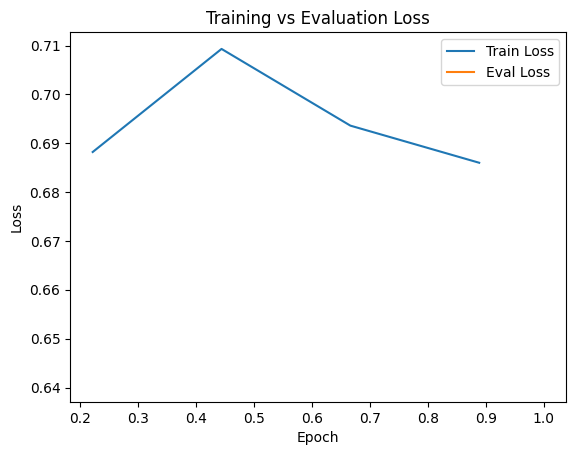

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert log history to a DataFrame
log = pd.DataFrame(trainer.state.log_history)

# Filter training and evaluation loss entries
train_log = log.dropna(subset=['loss'])
eval_log = log.dropna(subset=['eval_loss'])

# Plot training and evaluation losses
plt.plot(train_log["epoch"], train_log["loss"], label="Train Loss")
plt.plot(eval_log["epoch"], eval_log["eval_loss"], label="Eval Loss")

# Add legend and show plot
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.show()

![image](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/7KEnvtpUyNcJTINdArLf7A/loss%20dpo.png)


### Evaluate the DPO model


In [16]:
# Load again the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [20]:
# Set a seed for reproducibility
set_seed(31)


# Define parameters for response genearation
generation_config = GenerationConfig(
        # Use sampling to generate diverse text
        do_sample=True,
        # Top-k sampling parameter
        top_k=1,
        # Temperature parameter to control the randomness of the generated text
        temperature=0.1,
        # Maximum number of new tokens to generate
        max_new_tokens=25,
        # Use the end-of-sequence token as the padding token
        pad_token_id=tokenizer.eos_token_id
    )

# Define the input prompt for text generation
PROMPT = "Is eating animals cruel?"
# Tokenize prompt
inputs = tokenizer(PROMPT, return_tensors='pt')

# Generate response from DPO model
outputs = model.generate(**inputs, generation_config=generation_config)
# Decode the generated text
print("DPO response:",tokenizer.decode(outputs[0], skip_special_tokens=True))

# Load the pre-trained GPT2
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Generate response
outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text
print("GPT2 response:",tokenizer.decode(outputs[0], skip_special_tokens=True))

DPO response: Is eating animals cruel?

The answer is yes.

The Humane Society of the United States (HSUS) has been working with the
GPT2 response: Is eating animals cruel?

The answer is yes.

The Humane Society of the United States (HSUS) has been working with the


We can see the answers are not perfect and the reason is that we trained the DPO model for only 1 epoch. This notebook is a demonstration of how to implement DPO model and fine-tune your LLM.
